# Assignment 5

In this assignment, you'll scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Aggie for analysis in exercise 1.4.

__Exercise 1.1.__ Write a function that extracts all of the links to articles in an Aggie article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Have a parameter `page` for the number of pages to fetch links from. The default should be `1`.

* Return a list of aricle URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite to The Aggie and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* Start by getting your function to work for just 1 page. Once that works, have your function call itself to get additional pages.

* You can use [lxml.html](http://lxml.de/lxmlhtml.html) or [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape HTML. Choose one and use it throughout the entire assignment.

In [603]:
from urllib2 import Request, urlopen, HTTPError
from urlparse import urlunparse, urlparse
import json 
import requests_cache
import pandas as pd
import requests
from bs4 import BeautifulSoup
import urllib
import nltk
import numpy as np
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from scipy import sparse
plt.style.use('ggplot')
from nltk.corpus import stopwords
import string
%matplotlib inline
requests_cache.install_cache('coll_cache')

In [95]:
def article_url(url, page):
    """
    This function is used to extract all of the links to articles in an Aggie article list
    Args:
        url (string): The url of the article list
        page (int): The number of pages to fetch links from
    Returns:
        URL: a list of article urls
    """
    URL = []
    baseurl = [0]
    if page is None:
        baseurl[0] = url
    else:
        for n in range(page):
            urls = url + 'page/'+ str(n+1)+"/"
            baseurl.append(urls)
        baseurl.pop(0)
    for item in baseurl:
        r = urllib.urlopen(item).read()
        soup = BeautifulSoup(r)
        content = soup.find_all('div', class_="content_wrapper")
        for itm in content:
            get_url = itm.a["href"]
            URL.append(get_url)
    return URL

<b>Test the function on Campus News category, and get the links of first thirty pages by setting parameter page equals to 30<b>

In [102]:
article_url("https://theaggie.org/campus/", 30)

['https://theaggie.org/2017/02/24/2017-winter-quarter-election-results/',
 'https://theaggie.org/2017/02/23/university-of-california-davis-city-council-sever-wells-fargo-contracts/',
 'https://theaggie.org/2017/02/23/academics-unite-in-peaceful-rally-against-immigration-ban/',
 'https://theaggie.org/2017/02/23/memorial-union-to-reopen-spring-quarter/',
 'https://theaggie.org/2017/02/23/asucd-president-alex-lee-vetoes-amendment-for-creation-of-judicial-council/',
 'https://theaggie.org/2017/02/22/senate-candidate-zaki-shaheen-withdraws-from-race/',
 'https://theaggie.org/2017/02/21/uc-davis-experiences-several-recent-hate-based-crimes/',
 'https://theaggie.org/2017/02/21/uc-president-selects-gary-may-as-new-uc-davis-chancellor/',
 'https://theaggie.org/2017/02/20/katehi-controversy-prompts-decline-of-uc-administrators-seeking-profitable-subsidiary-board-positions/',
 'https://theaggie.org/2017/02/20/asucd-senate-passes-resolution-submitting-comments-on-lrdp/',
 'https://theaggie.org/201

<b>Test the function on Arts & Culture category. The default page is the first page.</b>

In [191]:
article_url("https://theaggie.org/arts/", page = None)

['https://theaggie.org/2017/02/23/sacramentos-artstreet-exhibit-showcases-diverse-artwork/',
 'https://theaggie.org/2017/02/23/armadillo-kdvs-collaborate-to-host-vinyl-and-music-fair/',
 'https://theaggie.org/2017/02/23/harlows-nightclub-presents-khalid/',
 'https://theaggie.org/2017/02/21/late-night-eats-in-davis/',
 'https://theaggie.org/2017/02/21/2017-oscar-nominations-and-predictions/',
 'https://theaggie.org/2017/02/20/student-sounds-samantha-sipin/',
 'https://theaggie.org/2017/02/20/tv-revisited-the-office/',
 'https://theaggie.org/2017/02/19/uc-davis-theater-and-dance-presents-its-newest-comedy/',
 'https://theaggie.org/2017/02/19/twenty-one-pilots-emotional-roadshow-world-tour/',
 'https://theaggie.org/2017/02/16/a-night-under-the-stars/',
 'https://theaggie.org/2017/02/14/critically-acclaimed-stand-up-comic-brian-regan-to-perform-at-mondavi-center/',
 'https://theaggie.org/2017/02/13/burning-love-parody-of-the-bachelor/',
 'https://theaggie.org/2017/02/12/the-bachelor-engage

<b> Test the function on Sports category, and get the links of the first thirty pages.</b>

In [103]:
article_url("https://theaggie.org/sports/", page = 30)

['https://theaggie.org/2017/02/24/uc-davis-back-on-track-with-win-over-matadors/',
 'https://theaggie.org/2017/02/24/aggie-womens-basketball-team-says-neigh-to-mustangs/',
 'https://theaggie.org/2017/02/23/the-amazeing-aggies/',
 'https://theaggie.org/2017/02/23/uc-davis-womens-water-polo-dominates-aggie-shootout/',
 'https://theaggie.org/2017/02/23/womens-gymnastics-take-two/',
 'https://theaggie.org/2017/02/21/what-are-your-thoughts-on-uc-davis-athletics/',
 'https://theaggie.org/2017/02/20/a-day-in-the-life-of-an-athletic-trainer/',
 'https://theaggie.org/2017/02/19/a-lifetime-of-tennis/',
 'https://theaggie.org/2017/02/17/uc-davis-womens-basketball-team-holds-off-uc-irvine-62-42/',
 'https://theaggie.org/2017/02/17/nba-awards-at-the-all-star-break/',
 'https://theaggie.org/2017/02/17/womens-lacrosse-soars-over-the-blackbirds/',
 'https://theaggie.org/2017/02/17/uc-davis-womens-lacrosse-falls-in-tough-season-opener/',
 'https://theaggie.org/2017/02/16/uc-davis-softball-falls-in-home

__Exercise 1.2.__ Write a function that extracts the title, text, and author of an Aggie article. The function should:

* Have a parameter `url` for the URL of the article.

* For the author, extract the "Written By" line that appears at the end of most articles. You don't have to extract the author's name from this line.

* Return a dictionary with keys "url", "title", "text", and "author". The values for these should be the article url, title, text, and author, respectively.

For example, for [this article](https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/) your function should return something similar to this:
```
{
    'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
    'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effort will mesh well with our other efforts as we build the budget for the next fiscal year and beyond." Project Toto complements the city\'s effort to amplify the transparency of city decisions to community members. The aim is to increase the understanding about the city\'s financial situation and make the information more accessible and easier to understand. The project is mostly a tool for public education, but can also make predictions about potential decisions regarding the city\'s financial future. Once completed, the program will allow residents to manipulate variables to see their eventual consequences, such as tax increases or extensions and proposed developments "This really isn\'t a budget, it is a forecast to see the intervention of these decisions," Williams said in an interview with The Davis Enterprise. "What happens if we extend the sales tax? What does it do given the other numbers that are in?" Project Toto enables users, whether it be a curious Davis resident, a concerned community member or a city leader, with the ability to project city finances with differing variables. The online program consists of the 400-page city budget for the 2016-2017 fiscal year, the previous budget, staff reports and consultant analyses. All of the documents are cited and accessible to the public within Project Toto. "It\'s a model that very easily lends itself to visual representation," Mayor Robb Davis said. "You can see the impacts of decisions the council makes on the fiscal health of the city." Complementary to this program, there is also a more advanced version of the model with more in-depth analyses of the city\'s finances. However, for an easy-to-understand, simplistic overview, Project Toto should be enough to help residents comprehend Davis finances. There is still more to do on the project, but its creators are hard at work trying to finalize it before the 2017-2018 fiscal year budget. "It\'s something I have been very much supportive of," Davis said. "Transparency is not just something that I have been supportive of but something we have stated as a city council objective [ ] this fits very well with our attempt to inform the public of our challenges with our fiscal situation." ',
    'title': 'Project Toto aims to address questions regarding city finances',
    'url': 'https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/'
}
```

Hints:

* The author line is always the last line of the last paragraph.

*   Python 2 displays some Unicode characters as `\uXXXX`. For instance, `\u201c` is a left-facing quotation mark.
    You can convert most of these to ASCII characters with the method call (on a string)
    ```
    .translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    ```
    If you're curious about these characters, you can look them up on [this page](http://unicode.org/cldr/utility/character.jsp), or read 
    more about [what Unicode is](http://unicode.org/standard/WhatIsUnicode.html).

In [652]:
def article_content(url):
    """
    This function extracts the title, text, and author of an Aggie article.
    Args:
        url (string): The url of the article 
    Returns:
        content: A dictionary with keys "url", "title", "text", and "author". 
                 The values for these should be the article url, title, text, and author, respectively
    """
    text = []
    r = urllib.urlopen(url).read()
    soup = BeautifulSoup(r)
    T = soup.find_all("h1", class_="entry-title")
    body = soup.find_all("div", itemprop = "articleBody")[0]
    C = body.find_all("p" or "strong")
    for itm in T:
        title = itm.get_text().translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    for itm in C:
        content = itm.get_text()
        text.append(content)
    try:
        C[-1].find_all("strong" and "span")[0].get_text()
        author = C[-1].find_all("strong")[0].get_text().translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
        text.pop(-1)
        lastpar = C[-1].find_all(strong = False)[0].get_text()
        text.append(lastpar)
    except:
        author = text[-1].translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
        text.pop(-1)
    total_text = u''.join(text).translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    dic={'author':author,'text':total_text, 'title':title, 'url':url} 
    return dic

Here we have to noticed that, for most articles, author line is the last paragraph without texts. But for some articles, author line is the last line with some texts of the article. So here I use trt/except to discuss these two situations to extract the specific contents.

In [653]:
article_content(url = "https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/")



{'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
 'text': u'Davis residents create financial model to make city\'s financial state more transparentTo increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto e

In [435]:
article_content(url = "https://theaggie.org/2017/02/23/academics-unite-in-peaceful-rally-against-immigration-ban/")



{'author': u'Written by: Kimia Akbari \u2014 campus@theaggie.org',
 'text': u'Faculty, students recount personal tales of immigration; highlight value of diversityUC Davis students, faculty and members of the Davis community gathered on the Quad on Feb. 9 to display their solidarity with those directly affected by President Donald Trump\'s immigration ban.In light of the recent executive order, universities across the country have organized similar rallies with the uniting objective of "Academics United \u2014 No Visa and Immigration Ban." Nazanin Akrami and Ellie White \u2014 both graduate students at UC Davis in cooperation with SEDAD, the Iranian graduate student association \u2014 were the organizers of this peaceful rally.The event was approximately an hour long, during which participants were prepared with rain ponchos, umbrellas and signs that displayed slogans such as "Love not hate makes the nation great" and "No ban, No wall, No Trump, No fear." It received publicity on multi

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get a data frame of 60 [Campus News](https://theaggie.org/campus/) articles and a data frame of 60 [City News](https://theaggie.org/city/) articles. Add a column to each that indicates the category, then combine them into one big data frame.

The "text" column of this data frame will be your corpus for natural language processing in exercise 1.4.


In [413]:
def get_df(url, page):
    """
    The function gets the dataframe of articles
    Args:
        url (string): The url of the article list
        page (int): The number of pages to fetch links from
    Returns:
        df_text: A data frame of articles contents
    """
    URL = article_url(url, page)
    content = []
    for itm in URL:
        arti = article_content(itm)
        content.append(arti)
    df_text = pd.DataFrame(content)
    return df_text

In [436]:
campus_df = get_df("https://theaggie.org/campus/",4)
campus_df


,author,text,title,url
0,Written by: Alyssa Vandenberg — campus@theagg...,"Six senators, new executive team electedCurren...",2017 Winter Quarter election results,https://theaggie.org/2017/02/24/2017-winter-qu...
1,Written by: Aaron Liss and Raul Castellanos —...,"Wells Fargo faces fraud, predatory lending cha...","University of California, Davis City Council s...",https://theaggie.org/2017/02/23/university-of-...
2,Written by: Kimia Akbari — campus@theaggie.org,"Faculty, students recount personal tales of im...",Academics unite in peaceful rally against immi...,https://theaggie.org/2017/02/23/academics-unit...
3,Written by: Kenton Goldsby — campus@theaggie.org,Opening date pushed back to May 1Students have...,Memorial Union to reopen Spring Quarter,https://theaggie.org/2017/02/23/memorial-union...
4,Written by: Ivan Valenzuela — campus@theaggie.org,Veto included revision abandoning creation of ...,ASUCD President Alex Lee vetoes amendment for ...,https://theaggie.org/2017/02/23/asucd-presiden...
5,Written by: Alyssa Vandenberg — campus@theagg...,"Shaheen's name to remain on ballot, his votes ...",Senate candidate Zaki Shaheen withdraws from race,https://theaggie.org/2017/02/22/senate-candida...
6,Written by: Aaron Liss — campus@theaggie.org,Students receive email warnings from UC Davis ...,UC Davis experiences several recent hate-based...,https://theaggie.org/2017/02/21/uc-davis-exper...
7,Written by: Alyssa Vandenberg — campus@theagg...,UC Board of Regents to vote on the appointment...,UC President selects Gary May as new UC Davis ...,https://theaggie.org/2017/02/21/uc-president-s...
8,Written by: Jeanna Totah — campus@theaggie.org,Tighter policies require greater approval of o...,Katehi controversy prompts decline of UC admin...,https://theaggie.org/2017/02/20/katehi-controv...
9,Written by: Ivan Valenzuela — campus@theaggie...,SR #7 asks university to increase capacity for...,ASUCD Senate passes resolution submitting comm...,https://theaggie.org/2017/02/20/asucd-senate-p...


In [437]:
city_df = get_df("https://theaggie.org/city/",4)
city_df


,author,text,title,url
0,Written by: Kaelyn Tuermer-Lee — city@theaggie...,Local Whole Foods closes Feb. 12After five yea...,Davis' Whole Foods Market shuts down,https://theaggie.org/2017/02/23/davis-whole-fo...
1,Written By: Anya Rehon — city@theaggie.org,Demonstrations take place at hundreds of Plann...,Protest against Planned Parenthood in Woodland...,https://theaggie.org/2017/02/23/protest-agains...
2,Written By: Bianca Antunez — city@theaggie.org,California Redevelopment Agencies require Davi...,Davis's Historic City Hall building to be put ...,https://theaggie.org/2017/02/23/daviss-histori...
3,Written by: Caitlyn Sampley — city@theaggie.org,Davis residents show solidarity in wake of tra...,Davis stands with Muslim residents,https://theaggie.org/2017/02/21/davis-stands-w...
4,"To help the campus reach its goal, Vang recomm...","CalRecycle donates $197,851The City of Davis w...",City of Davis awarded funds for new recycling ...,https://theaggie.org/2017/02/20/city-of-davis-...
5,"""Chicken trying to cross the road, loitering a...","The world is a weird placeFeb. 6""Chronic phone...",Police Logs,https://theaggie.org/2017/02/19/police-logs-12/
6,Written by: Raul Castellanos Jr — city@theaggi...,Mayor Robb Davis reaffirms that the City of Da...,City of Davis to retain sanctuary city status,https://theaggie.org/2017/02/16/city-of-davis-...
7,Written by: Samantha Solomon — city@theaggie.org,Davis resident Lauren Kirk-Coehlo arrested in ...,Suspect in Davis Islamic Center vandalism arre...,https://theaggie.org/2017/02/15/suspect-in-dav...
8,Written By: Bianca Antunez — city@theaggie.org,Davis residents create financial model to make...,Project Toto aims to address questions regardi...,https://theaggie.org/2017/02/14/project-toto-a...
9,"""Ongoing issue with parents parking in the whi...","Something smells fishyJan. 29 ""Loud music or T...",Police Logs,https://theaggie.org/2017/02/13/police-logs-11/


In [438]:
category1 = pd.Series(['Campus News']*len(campus_df), name = 'category')
category2 = pd.Series(['City News']*len(city_df), name = 'category')
campus_df = pd.concat([campus_df,pd.Series(category1).rename('category')],axis = 1)
city_df = pd.concat([city_df,pd.Series(category2).rename('category')],axis = 1)

In [439]:
df = campus_df.append(city_df, ignore_index = True)



In [440]:
df



,author,text,title,url,category
0,Written by: Alyssa Vandenberg — campus@theagg...,"Six senators, new executive team electedCurren...",2017 Winter Quarter election results,https://theaggie.org/2017/02/24/2017-winter-qu...,Campus News
1,Written by: Aaron Liss and Raul Castellanos —...,"Wells Fargo faces fraud, predatory lending cha...","University of California, Davis City Council s...",https://theaggie.org/2017/02/23/university-of-...,Campus News
2,Written by: Kimia Akbari — campus@theaggie.org,"Faculty, students recount personal tales of im...",Academics unite in peaceful rally against immi...,https://theaggie.org/2017/02/23/academics-unit...,Campus News
3,Written by: Kenton Goldsby — campus@theaggie.org,Opening date pushed back to May 1Students have...,Memorial Union to reopen Spring Quarter,https://theaggie.org/2017/02/23/memorial-union...,Campus News
4,Written by: Ivan Valenzuela — campus@theaggie.org,Veto included revision abandoning creation of ...,ASUCD President Alex Lee vetoes amendment for ...,https://theaggie.org/2017/02/23/asucd-presiden...,Campus News
5,Written by: Alyssa Vandenberg — campus@theagg...,"Shaheen's name to remain on ballot, his votes ...",Senate candidate Zaki Shaheen withdraws from race,https://theaggie.org/2017/02/22/senate-candida...,Campus News
6,Written by: Aaron Liss — campus@theaggie.org,Students receive email warnings from UC Davis ...,UC Davis experiences several recent hate-based...,https://theaggie.org/2017/02/21/uc-davis-exper...,Campus News
7,Written by: Alyssa Vandenberg — campus@theagg...,UC Board of Regents to vote on the appointment...,UC President selects Gary May as new UC Davis ...,https://theaggie.org/2017/02/21/uc-president-s...,Campus News
8,Written by: Jeanna Totah — campus@theaggie.org,Tighter policies require greater approval of o...,Katehi controversy prompts decline of UC admin...,https://theaggie.org/2017/02/20/katehi-controv...,Campus News
9,Written by: Ivan Valenzuela — campus@theaggie...,SR #7 asks university to increase capacity for...,ASUCD Senate passes resolution submitting comm...,https://theaggie.org/2017/02/20/asucd-senate-p...,Campus News


__Exercise 1.4.__ Use the Aggie corpus to answer the following questions. Use plots to support your analysis.

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

* Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

Hints:

*   The [nltk book](http://www.nltk.org/book/) and [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) may be helpful here.

*   You can determine whether city articles are "near" campus articles from the similarity matrix or with k-nearest neighbors.

*   If you want, you can use the [wordcloud](http://amueller.github.io/word_cloud/) package to plot a word cloud. To install the package, run
    ```
    conda install -c https://conda.anaconda.org/amueller wordcloud
    ```
    in a terminal. Word clouds look nice and are easy to read, but are less precise than bar plots.

<b>Part 1</b>

In [529]:
campus_text = campus_df['text']
city_text = city_df['text']
Text = df['text']



In [530]:
StopWords = stopwords.words("english")+list(string.punctuation)+['','``','\'s','the','i',"''"]
def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    tokenize = nltk.word_tokenize
    return stem(tokenize(text))

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens if w not in StopWords]



In [560]:
def get_topic(text):
    """
    Construct the dictionary to convert the lemmata to document ids containing that lemma
    Input: the text
    Output: the dictionary whose key is the lemmata and the value is the document ids
    """
    textd = {}
    for i in range(len(text)):
        s = set(lemmatize(text[i]))
        try:
            toks = toks|s
        except NameError:
            toks = s
        for tok in s:
            try:
                textd[tok].append(i)
            except KeyError:
                textd[tok] = [i]
    numd = {key:len(set(val)) for key,val in textd.items()}
    return numd


In [561]:
cam_textd = get_topic(campus_text)
ci_textd = get_topic(city_text)
aggie_textd = get_topic(Text)


In [577]:
def get_freq(numd):
    """
    get the ranking of the topics in the text
    Input: the dictionary
    Output: the 
    """
    for w in sorted(numd, key = numd.get, reverse = True):
        print w ,numd[w] 
        

In [578]:
get_freq(aggie_textd)


said 105
the 100
davi 97
also 77
i 77
uc 76
commun 74
student 73
one 72
it 71
year 70
peopl 66
we 64
work 63
mani 62
like 62
make 60
go 56
new 56
major 54
n't 54
provid 53
help 52
support 51
in 51
presid 51
thi 50
campu 50
includ 50
come 50
time 49
need 49
state 49
california 48
realli 45
educ 45
would 45
member 45
jan. 44
continu 43
get 43
accord 42
plan 41
two 41
use 41
organ 41
want 40
think 40
believ 39
see 39
well 39
univers 39
first 39
abl 39
day 39
local 39
— 38
public 38
there 38
take 37
issu 37
program 37
citi 36
could 36
resid 36
servic 36
school 36
place 36
current 35
around 35
manag 35
sinc 35
fund 35
us 35
event 35
receiv 35
recent 34
way 34
call 34
inform 34
right 33
last 33
hope 33
look 33
thing 33
're 33
associ 33
part 33
addit 33
director 32
import 32
next 31
order 31
know 31
creat 30
offic 30
chang 30
feel 30
project 29
person 29
great 29
system 29
opportun 29
concern 29
kind 29
nation 28
open 28
past 28
put 28
even 28
may 28
resourc 28
bring 27
administr 27
lot 27
th

According to the result, we can see after ignoring some verbs and adjectives, the Aggie covers the "ucdavis" and "community" and "student" most.

In [581]:
for w in sorted(cam_textd, key = cam_textd.get, reverse = True)[0:20]:
    print w ,cam_textd[w]
    

said 55
student 55
uc 55
the 53
davi 52
also 47
i 46
campu 43
work 38
major 38
new 37
presid 37
one 36
univers 36
commun 36
we 34
make 32
educ 32
includ 32
jan. 31


In [582]:
for w in sorted(ci_textd, key = ci_textd.get, reverse = True)[0:20]:
    print w ,ci_textd[w]
    

said 50
the 47
davi 45
it 41
year 39
commun 38
one 36
peopl 35
like 32
mani 31
i 31
we 30
also 30
go 29
make 28
local 28
resid 28
thi 27
citi 27
in 26


In [590]:
for i in list(set(ci_textd)-set(cam_textd)):
    if ci_textd[i] >= 10:
        print i,ci_textd[i]
        

street 20


In [589]:
for i in list(set(cam_textd)-set(ci_textd)):
    if cam_textd[i] >= 15:
        print i,cam_textd[i]
        

faculti 15


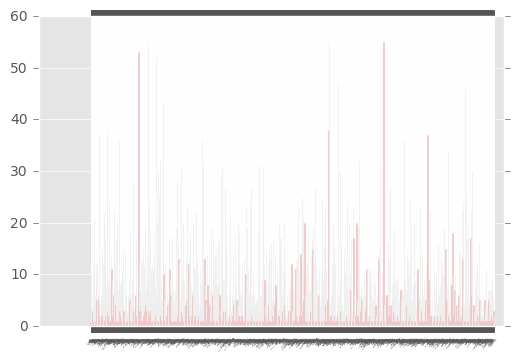

In [592]:
plt.bar(range(len(cam_textd)), cam_textd.values(), align = 'center', color = 'r')
plt.xticks(range(len(cam_textd)), cam_textd.keys(),rotation = '50',size = 1)
plt.show()


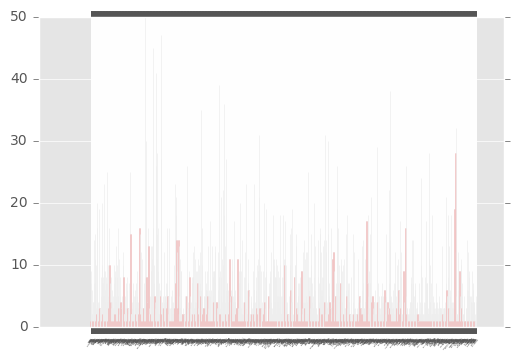

In [593]:
plt.bar(range(len(ci_textd)), ci_textd.values(), align = 'center', color = 'r')
plt.xticks(range(len(ci_textd)), ci_textd.keys(),rotation = '50',size = 1)
plt.show()


(array([  2.97100000e+03,   3.08000000e+02,   1.97000000e+02,
          7.70000000e+01,   7.30000000e+01,   2.90000000e+01,
          3.10000000e+01,   1.00000000e+01,   1.10000000e+01,
          4.00000000e+00,   6.00000000e+00,   6.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00]),
 array([  1.  ,   3.45,   5.9 ,   8.35,  10.8 ,  13.25,  15.7 ,  18.15,
         20.6 ,  23.05,  25.5 ,  27.95,  30.4 ,  32.85,  35.3 ,  37.75,
         40.2 ,  42.65,  45.1 ,  47.55,  50.  ]),
 <a list of 20 Patch objects>)

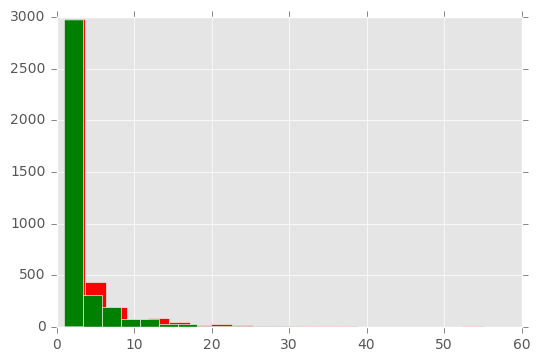

In [599]:
plt.hist(cam_textd.values(),bins=20, color = 'r'); plt.hist(ci_textd.values(),bins=20,color = 'g')


From the result above, we can see the city article kind of cover different topics than campus articles, since street covers 20 times in city article which is not present in campus article. But on the other hand, they also cover many same topics because there are some words only show several times.

<b>Part 2</b> 

In [601]:
vectorizer = TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True,norm=None)
tfs = vectorizer.fit_transform(Text)
sim = tfs.dot(tfs.T)
print np.mean(sim[0:60,61:120])
print sim.mean()


441.241559373
631.888335016


As we can see the mean of  similarity matrix for campus articles and city articles is much smaller than the totall mean of similarity matrix. We can infer that city articles cover different topics than campus articles.

Then I want to get the cosine similarity matrix and make the diagonal elements equal to 0. After converting the matrix into a list, I sorted the list and got the first 3 most similarity element and there index in the similarity matrix.

In [610]:
tfs_sparse = sparse.csr_matrix(tfs)
similarities = cosine_similarity(tfs_sparse)
matrix = similarities-np.diag(np.diag(similarities))


In [611]:
List = matrix.flatten()
List.sort()
T3 = list(set(List[-6:]))
print T3
for i in T3:
    print np.where(matrix == i)
    

[0.57311384908061447, 0.57765414782193314, 0.69662096278581553]
(array([51, 58]), array([58, 51]))
(array([24, 38]), array([38, 24]))
(array([14, 35]), array([35, 14]))


In [625]:
Title = df['title']
print Title[14]
print Title[35]
print Title[24]
print Title[38]
print Title[51]
print Title[58]


UC Davis holds first mental health conference
UC Davis to host first ever mental health conference
University of California Regents meet, approve first tuition raise in six years
UC Regents vote to raise tuition for UC campuses
Protests erupt at Milo Yiannopoulos event
Davis College Republicans club leads protest against cancellation of Milo Yiannopoulos event


* From the results, the first pair is "UC Davis holds first mental health conference" and "UC Davis to host first ever mental health conference". We can see they talk about the same topic about mental health conference and most of title words are the same, like "UC Davis", "first","mental", "health", "conference". So according to the title, we can infer they are the most similar articles.
* For the second pair, "University of California Regents meet, approve first tuition raise in six years" and "UC Regents vote to raise tuition for UC campuses". Both of them are saying the tuition raising.
* For the third pair, "Protests erupt at Milo Yiannopoulos event" and Davis College Republicans club leads protest against cancellation of Milo Yiannopoulos event". Similar to pair 1, they are talking about the same thing about "Milo Yiannopoulos". So we can think they are similar.

Let's emamine in the details and see what words these similar articles have in common.

In [628]:
t11 = set(lemmatize(Text[14]))
t12 = set(lemmatize(Text[35]))
print t11&t12


set([u'help', u'founder', u'text', u'month', u'involv', u'group', u'lgbtqia', u'monica', u'break', u'psychologist', u'tri', u'administr', u'organ', u'gender', u'panelist', u'she', u'crisi', u'prevent', u'set', u'mental', u'realli', u'close', u'beyond', u'juliet', u'spiritu', u'abl', u'p.m.', u'health', u'approach', u'porter', u'we', u'full', u'confer', u'destigmat', u'bodi', u'host', u'base', u'come', u'panel', u'remark', u'english', u'attende', u'a.m.', u'advocaci', u'studi', u'disabl', u'first', u'major', u'inspir', u'suicid', u'right', u'opportun', u'third-year', u'open', u'select', u'feb.', u'use', u'spoke', u'commun', u'there', u'two', u'workshop', u'advoc', u'includ', u'offer', u'forb', u'heal', u'took', u'fund', u'line', u'davi', u'counsel', u'work', u'aim', u'nine', u'three', u'psycholog', u'uc', u'150', u'engag', u'applic', u'process', u'want', u'in', u'onlin', u'secur', u'perform', u'speaker', u'peopl', u'9', u'place', u'attend', u'samantha', u'after', u'director', u'said', u

In [629]:
t21 = set(lemmatize(Text[24]))
t22 = set(lemmatize(Text[38]))
print t21&t22


set([u'among', u'336', u'direct', u'gavin', u'hook', u'cost', u'\u2014', u'year', u'vote', u'26', u'said', u'regent', u'debat', u'new', u'282', u'public', u'higher', u'we', u'newsom', u'lee', u'afford', u'tuition', u'fee', u'let', u'student', u'commit', u'increas', u'sinc', u'alex', u'i', u'54', u'servic', u'rais', u"n't", u'jan.', u'place', u'presid', u'california', u'the', u'crisi', u'uc', u'first'])


In [630]:
t31 = set(lemmatize(Text[51]))
t32 = set(lemmatize(Text[58]))
print t31&t32


set([u'claim', u'major', u'crowd', u'danger', u'feel', u'the', u'back', u'america', u'held', u'violent', u'pressur', u'want', u'go', u'milo', u'hate', u'event', u'damag', u'again', u'said', u'give', u'would', u'start', u'dcr', u'support', u'univers', u'due', u'p.m.', u'also', u'black', u'lot', u'sacramento', u'speech', u'speak', u'hat', u'cancel', u'make', u'we', u'thi', u'attend', u'get', u'read', u'peopl', u'hundr', u'protect', u'free', u'it', u'host', u'facebook', u'student', u'yiannopoulo', u'republican', u'come', u'minut', u'davi', u'14', u'great', u'word', u'like', u'i', u'local', u'howev', u'properti', u'well', u'protest', u'face', u"n't", u'matter', u'tour', u'jan.', u'came', u'outsid', u'time', u'colleg', u'went', u'campu', u'page', u'uc'])


<b>Part 3</b> 

I think we can not consider this corpus is the representative of the Aggie. Since the corpus only contains the first 4 pages for both Campus News and City News category. The corpus sample size is too small to support the analysis for the whole articles. According to our analysis, this corpus can support that the nearlist Campus News and City News articles cover the different topics.

In [631]:
df['url'][92]


'https://theaggie.org/2017/01/15/yolo-county-library-materials-to-be-more-widely-available/'